In [1]:
#Third party packages
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Custom packages
from SQL.load_rows import load_cluster_labels, load_a_cluster_label, load_intensity, load_audio_data
import Audio.cluster_audio_features as cluster_funcs


In [2]:
def import_class_data(youtube_id, folder = '~/Insight2017/Labelled_Data/'):
    filename = folder+str(youtube_id)+'.csv'
    try: classification_results = pd.read_csv(filename, header=None, names=['Time','Speaker'])
    except IOError:
        print('No file found, check youtube ID and folder!')
    return classification_results

def speaker_label_to_num(classification_results):
    '''takes string labels for speaker like A or B and
    converts to unique integers'''
    labels = classification_results.Speaker.unique()
    classes = classification_results.Speaker.values
    int_labels = np.zeros(classification_results.Speaker.shape)
    for n, label in enumerate(labels):
        int_labels[classes==label] = n
        
    return int_labels

def time_string_to_sec(classification_results):
    '''convert from mm:ss time string into seconds'''
    times = np.zeros(classification_results.Time.shape)
    
    for n,time in enumerate(classification_results.Time):
        elements = time.split(":")
        times[n] = 60*int(elements[0])+int(elements[1])
    return times

def produce_speaker_vector(times, classification_results):
    '''takes some hand-recorded data for speakers in a video and uses them
    to classify the speaker for every time element in the time vector "times" '''
    
    results = np.zeros(times.shape)
    
    class_times = time_string_to_sec(classification_results)
    class_labels = speaker_label_to_num(classification_results)
    
    results[times<class_times[0]] = class_labels[0]
    for n,label in enumerate(class_labels):
        speaker_times = (times<class_times[n]) & (times > class_times[n-1])
        results[speaker_times] = label
        
    return results

In [3]:
youtube_id = 'GD7GNO08Epg'

cluster_df = load_cluster_labels(youtube_id)
cluster_times = cluster_df['time'].as_matrix()
cluster_labels = cluster_df['cluster_label_raw'].as_matrix()

In [4]:
class_df = import_class_data(youtube_id)

t_max = time_string_to_sec(class_df).max()
true_classes = produce_speaker_vector(cluster_times, class_df).astype(int)
#there are some 2s in here, force them to one
true_classes[true_classes > 1] = np.ones(true_classes.shape)[true_classes > 1]


In [5]:
audio_df = load_audio_data(youtube_id)
Feature_Time = audio_df['time'].as_matrix()
Features = audio_df.iloc[:,2:36].as_matrix()

In [6]:
print(Features.shape)
print(true_classes.shape)

(2155, 34)
(2155,)


In [7]:
def prep_features(features, feature_mask):
    '''select desired features and normalize them for PCA'''
    #also need to transpose because PCA works on axis=1
    features_masked = features[:,feature_mask]
    return features_masked
desired_features = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
feature_mask = [feature in desired_features for feature in range(Features.shape[1])]
Features_masked = prep_features(Features,feature_mask)

In [79]:
print(Features_masked.shape)
print(true_classes.shape)
print(true_classes.mean())

(2155, 13)
(2155,)
0.44686774942


Reduce Dimensionality with t-SNE
--

In [22]:
from sklearn import datasets
from sklearn.manifold import TSNE

Features_tSNE = TSNE(learning_rate=100).fit_transform(Features_masked)

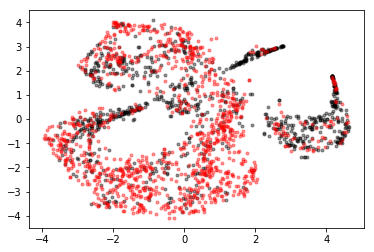

In [23]:
true_classes = true_classes.astype(bool)
plt.plot(Features_tSNE[true_classes,0], Features_tSNE[true_classes,1],'.k', alpha = 0.4)
plt.plot(Features_tSNE[np.logical_not(true_classes),0], Features_tSNE[np.logical_not(true_classes),1],'.r', alpha=0.4)

Reduce Dimensionality with PDA
==

Use only the Chroma Features

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

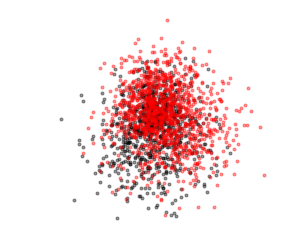

In [83]:
Chroma_features = [20,21,22,23,24,25,26,27,28,29,30,31,32]
MFCC_plus_spectral = [ 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
feature_mask = [feature in MFCC_plus_spectral for feature in range(Features.shape[1])]
Features_masked = prep_features(Features,feature_mask)

pca = PCA(n_components = 2)
feature_normed = normalize(Features_masked, axis=0)
pca.fit(feature_normed)
Features_PCA = pca.transform(feature_normed)

plt.figure(figsize=(4,4))
plt.plot(Features_PCA[true_classes,0], Features_PCA[true_classes,1],'.k', alpha = 0.4)
plt.plot(Features_PCA[np.logical_not(true_classes),0], Features_PCA[np.logical_not(true_classes),1],'.r', alpha=0.4)
lim = plt.axis('off')
plt.savefig('Chroma_features.png')

Use only the MFCC Features

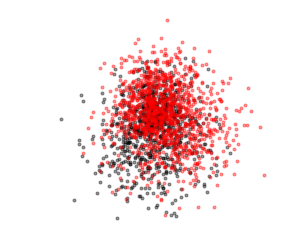

In [76]:
MFCC_features = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
feature_mask = [feature in MFCC_features for feature in range(Features.shape[1])]
Features_masked = prep_features(Features,feature_mask)

pca = PCA(n_components = 2)
feature_normed = normalize(Features_masked, axis=0)
pca.fit(feature_normed)
Features_PCA = pca.transform(feature_normed)

plt.figure(figsize=(4,4))
plt.plot(Features_PCA[true_classes,0], Features_PCA[true_classes,1],'.k', alpha = 0.4)
plt.plot(Features_PCA[np.logical_not(true_classes),0], Features_PCA[np.logical_not(true_classes),1],'.r', alpha=0.4)
lim = plt.axis('off')
plt.savefig('MFCC_features.png')

Use ZCR, Signal Centroid, etc...

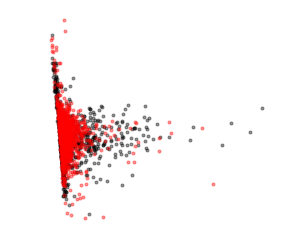

In [74]:
Other_features = [0,1,2,3,4,5,6,7]
feature_mask = [feature in Other_features for feature in range(Features.shape[1])]
Features_masked = prep_features(Features,feature_mask)

pca = PCA(n_components = 2)
feature_normed = normalize(Features_masked, axis=0)
pca.fit(feature_normed)
Features_PCA = pca.transform(feature_normed)

plt.figure(figsize=(4,4))
plt.plot(Features_PCA[true_classes,0], Features_PCA[true_classes,1],'.k', alpha = 0.4)
plt.plot(Features_PCA[np.logical_not(true_classes),0], Features_PCA[np.logical_not(true_classes),1],'.r', alpha=0.4)
plt.xlim(-0.02, 0.15)
lim = plt.axis('off')
plt.savefig('ZCR_Energy_Spectral_Statistics.png')

Use both Chroma and MFCCs

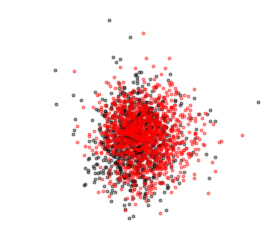

In [75]:
MFCC_Chroma_features = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,22,23,24,25,26,27,28,29,30,31,32]
feature_mask = [feature in MFCC_Chroma_features for feature in range(Features.shape[1])]
Features_masked = prep_features(Features,feature_mask)

pca = PCA(n_components = 2)
feature_normed = normalize(Features_masked, axis=0)
pca.fit(feature_normed)
Features_PCA = pca.transform(feature_normed)

plt.figure(figsize=(4,4))
plt.plot(Features_PCA[true_classes,0], Features_PCA[true_classes,1],'.k', alpha = 0.4)
plt.plot(Features_PCA[np.logical_not(true_classes),0], Features_PCA[np.logical_not(true_classes),1],'.r', alpha=0.4)
lim = plt.axis('off')
plt.savefig('MFCC_and_Chroma.png')